In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import glob
import argparse
sys.path.append('../')
import mplhep as hep
plt.style.use(hep.style.ROOT)

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

import logging
from pathlib import Path
from dotenv import find_dotenv, load_dotenv
import argparse
import awkward as ak
import pandas as pd
import mplhep as hep
import os
import os.path as osp
import h5py
import json

In [3]:
save_path = "../data/val"
with h5py.File(f'{save_path}/val_20_30.h5', 'r') as hdf:
        # Access the dataset containing your JSON strings
    dataset = hdf["subjets"]
    
    # Initialize a list to hold the deserialized subjets data
    subjets_data = []
    particles_features = hdf["particles"]["features"][:]
    particles_labels = hdf["particles"]["labels"][:]
    
    # Iterate over each JSON string in the dataset
    for json_str in dataset:
        # Deserialize the JSON string to a Python object
        subjet = json.loads(json_str)
        subjets_data.append(subjet)

# At this point, `subjets_data` contains all your subjets as Python dictionaries

In [4]:
subjets_data[0]

[{'features': {'pT': 563.1187802221922,
   'eta': 0.4276622300992181,
   'phi': 5.0734595349950595,
   'num_ptcls': 15},
  'indices': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1]},
 {'features': {'pT': 1.510839984817427,
   'eta': 0.22092145983146855,
   'phi': 4.798626009085173,
   'num_ptcls': 1},
  'indices': [13,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1]},
 {'features': {'pT': 0.7901196532137233,
   'eta': 0.38500146680738173,
   'phi': 5.637305968868835,
   'num_ptcls': 1},
  'indices': [16,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
   -1,
  

In [3]:
def get_num_real_subjets(jet):
    """
    return the number of non-empty subjets in a jet
    """
    num_real_subjets = 0
    for i in range(20):
        subjet = jet[i]
        if subjet['features']['pT'] > 0:
            num_real_subjets += 1
    return num_real_subjets

In [4]:
def find_good_jets(num):
    """
    Find num jets with more than 10 non-empty subjets
    """
    good_jets = []
    jet_idx = 0
    while len(good_jets) < num:
        jet = subjets_data[jet_idx]
        num_real_subjets = get_num_real_subjets(jet)
        if num_real_subjets >= 10:
            good_jets.append(jet)
            print(f"{len(good_jets)}th good jet found")
        jet_idx += 1
    return good_jets
    

In [5]:
good_jets = find_good_jets(10)

1th good jet found
2th good jet found
3th good jet found
4th good jet found
5th good jet found
6th good jet found
7th good jet found
8th good jet found
9th good jet found
10th good jet found


In [6]:
for jet in good_jets:
    print(get_num_real_subjets(jet))

10
15
13
17
11
10
10
14
12
12


## To plot the subjets within a jet

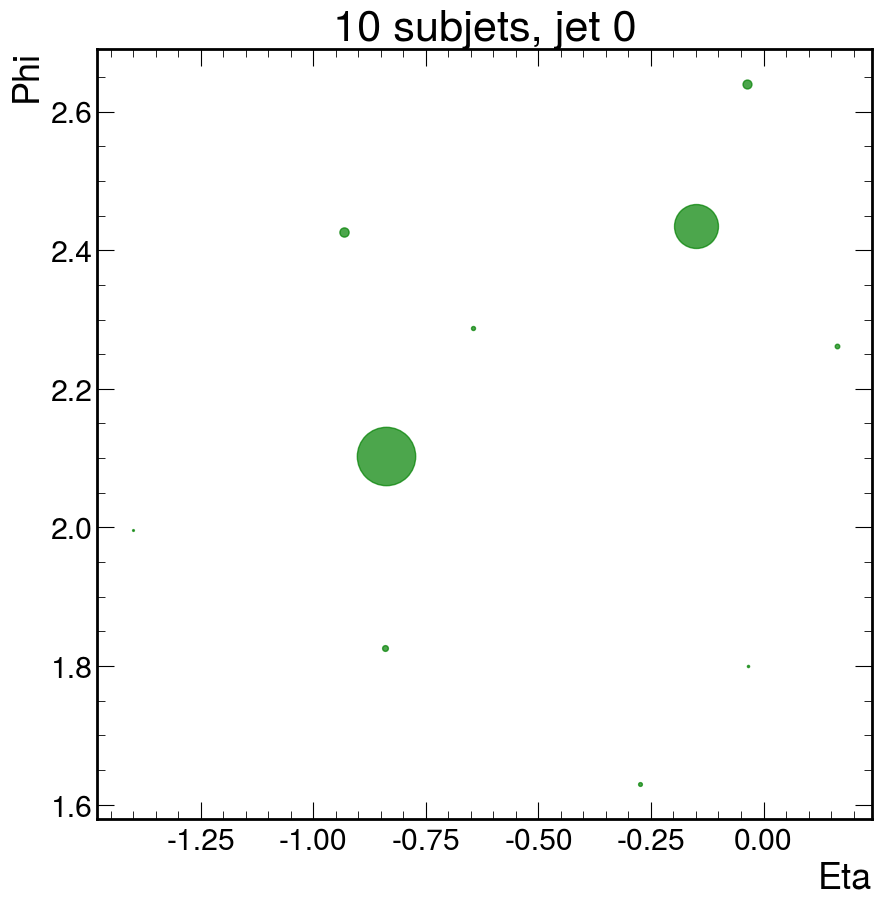

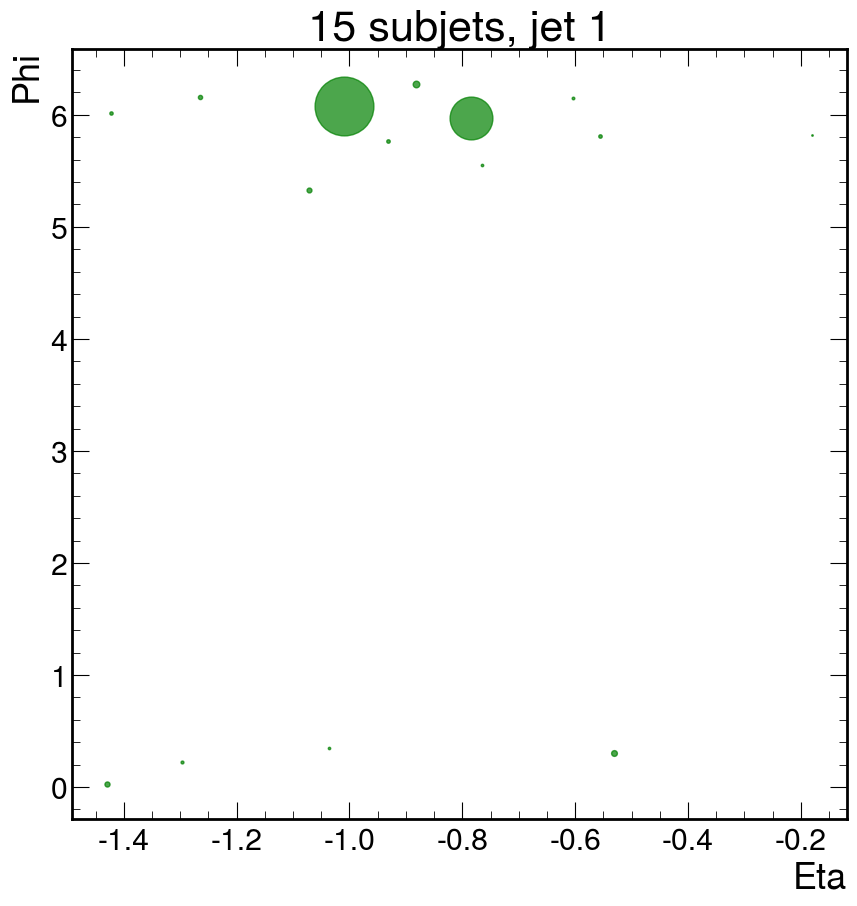

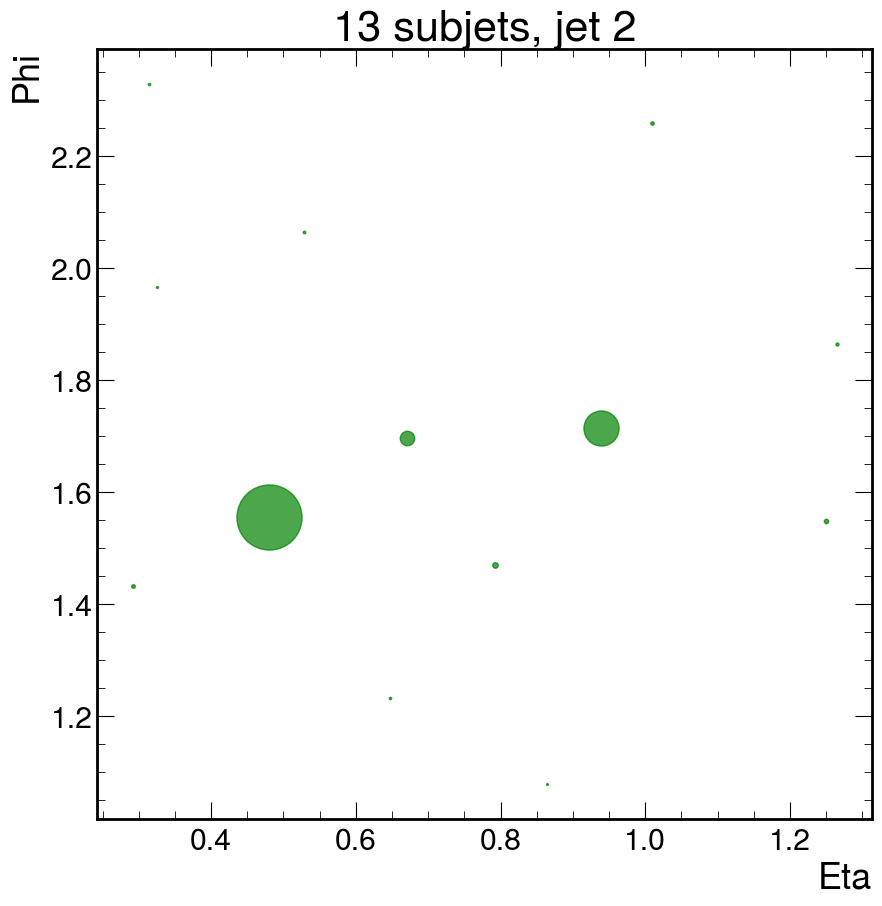

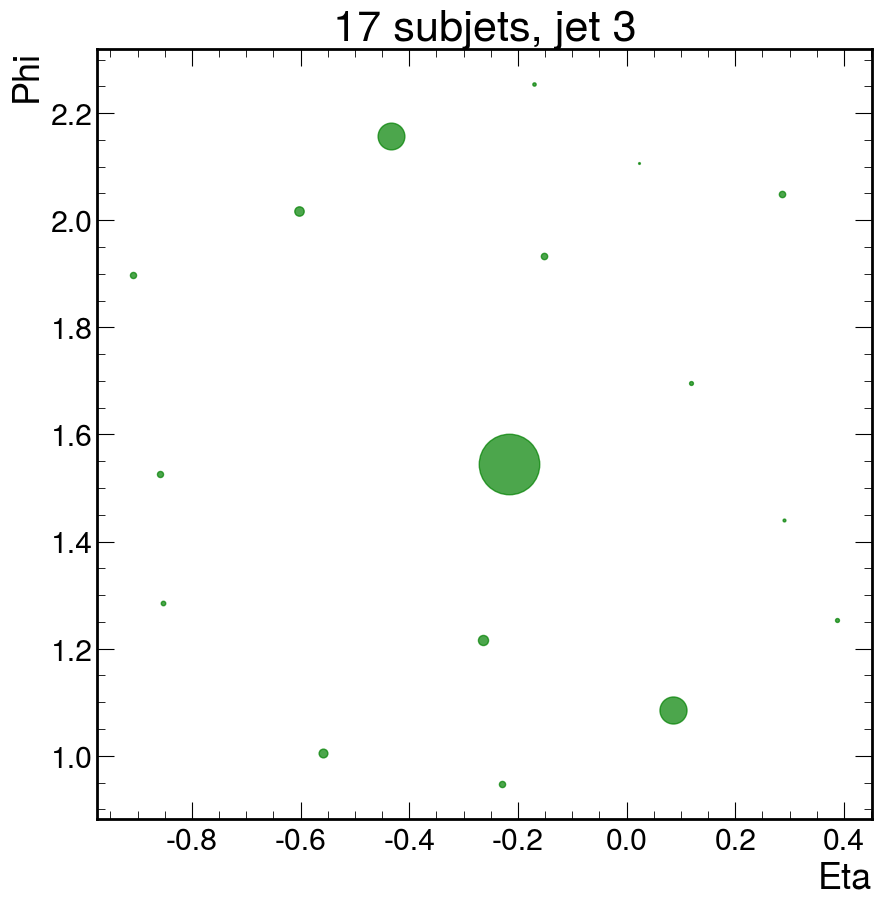

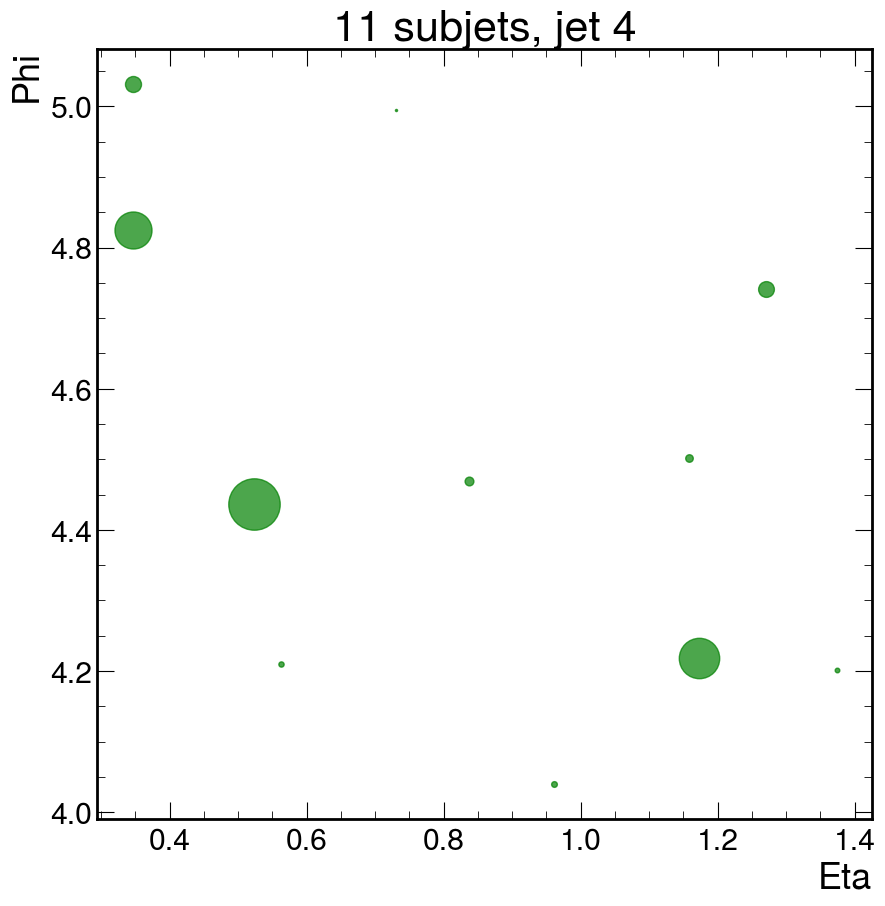

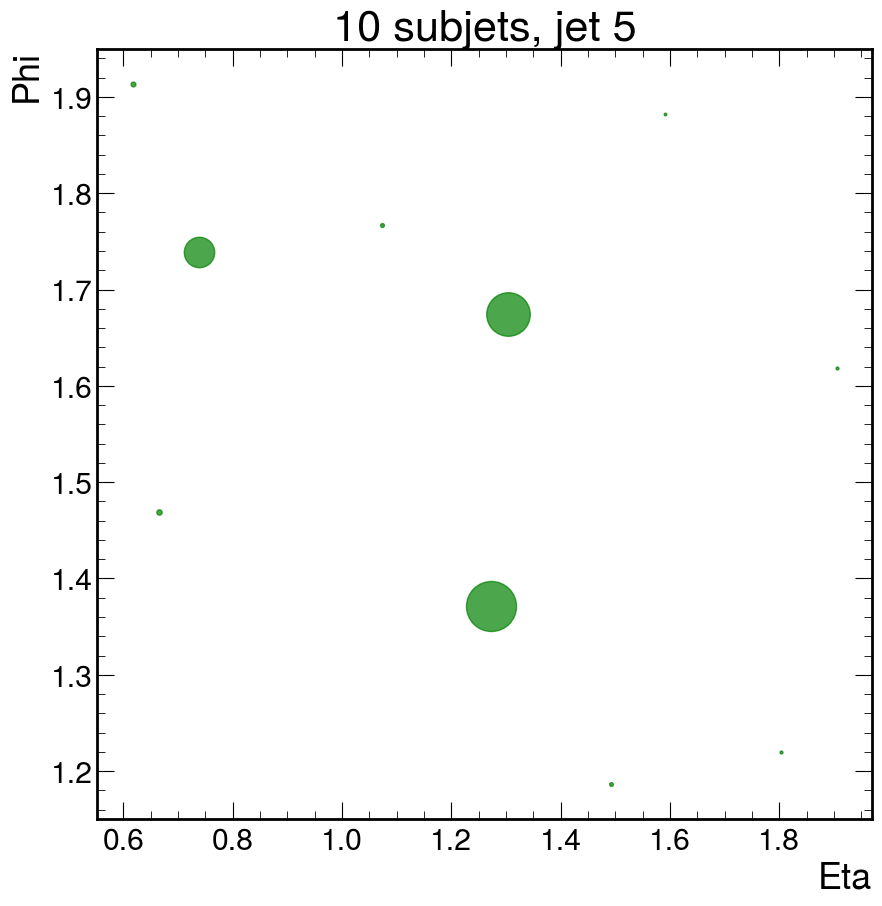

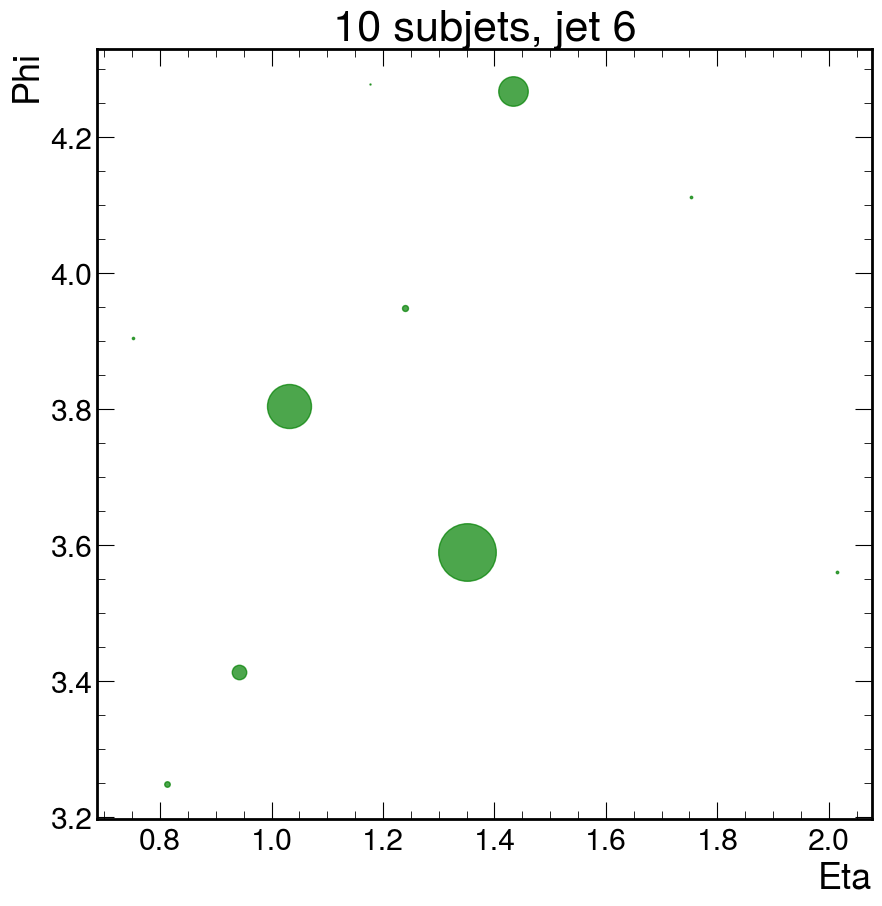

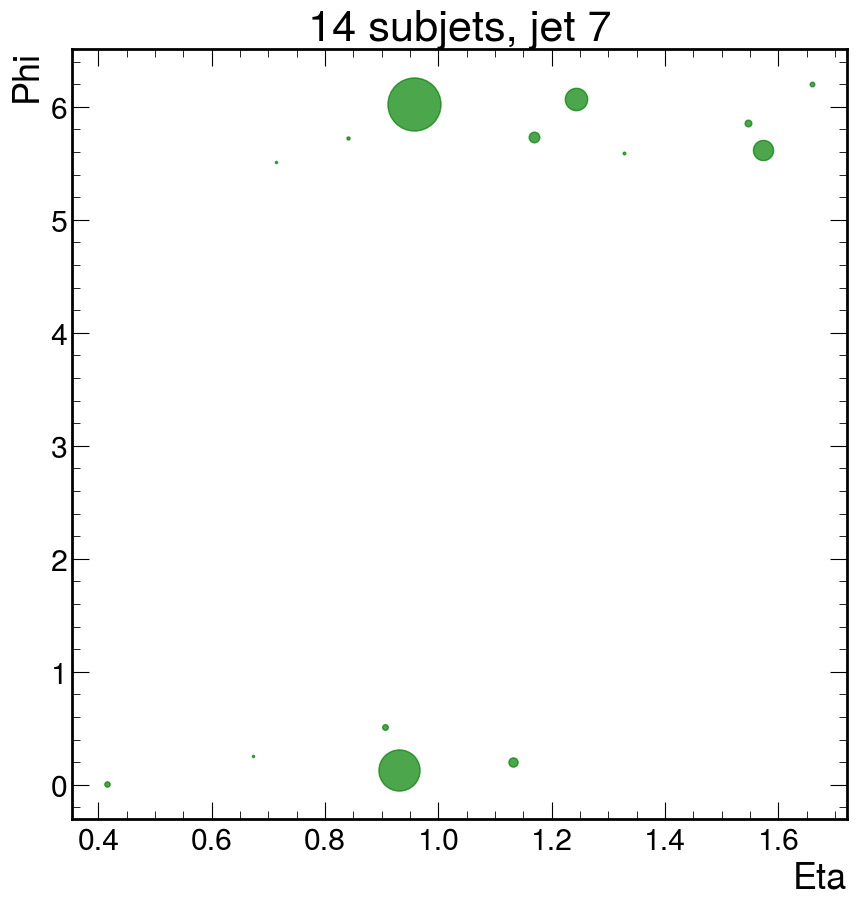

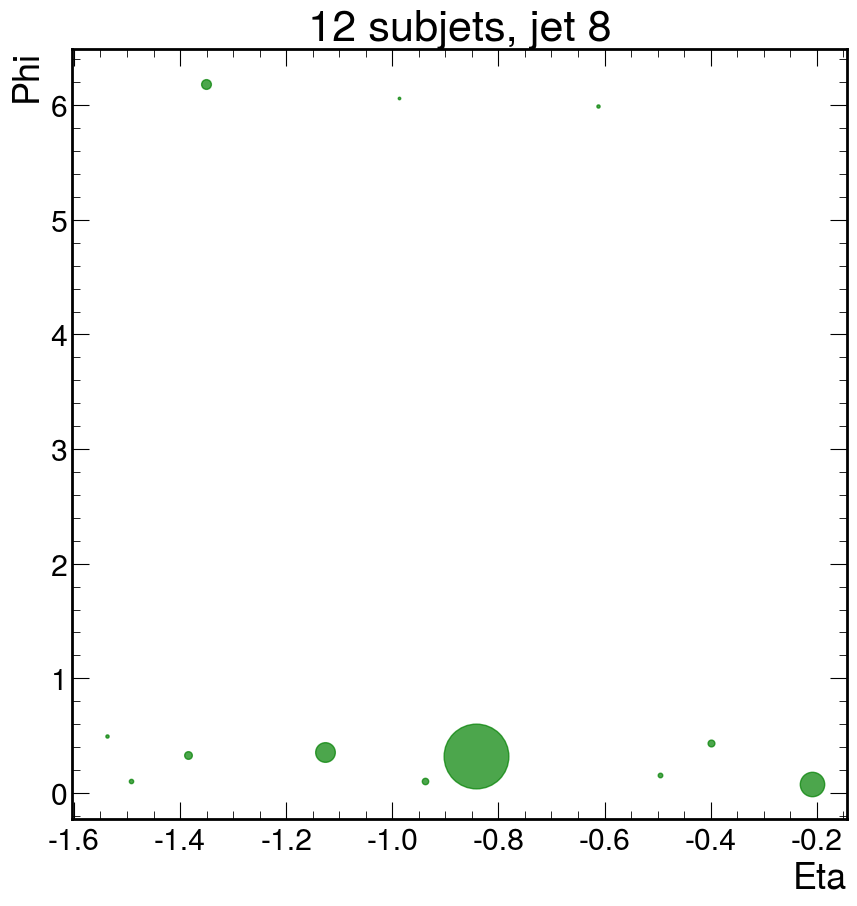

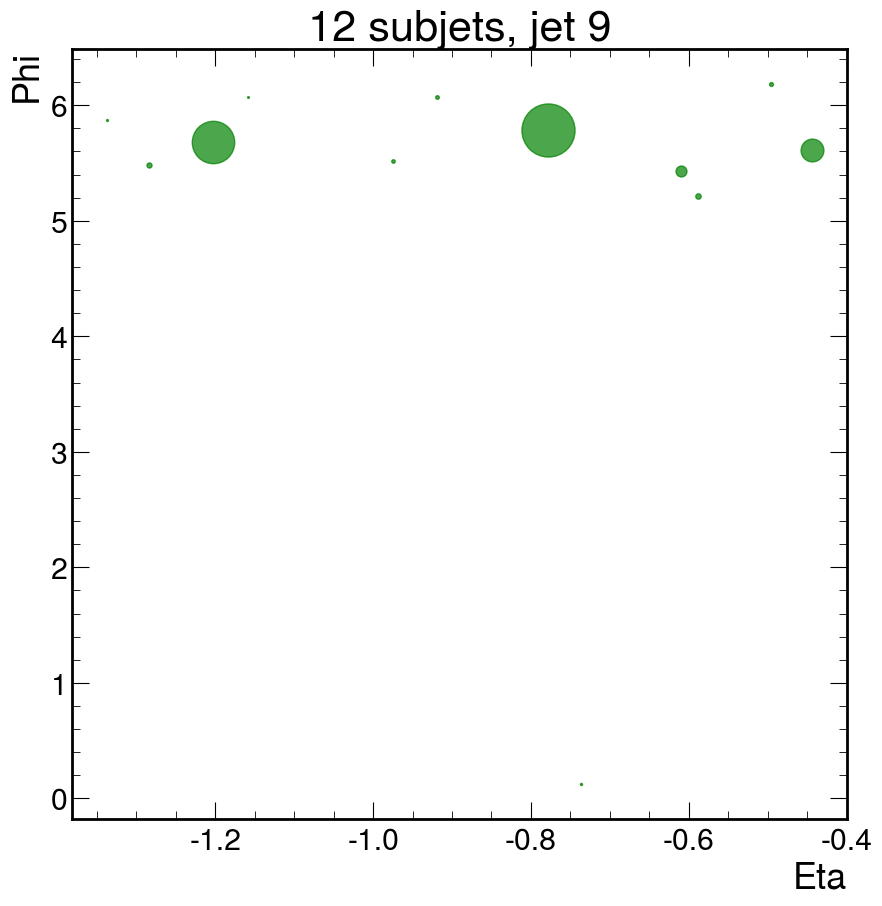

In [36]:
for jet_idx in range(len(good_jets)):
    jet_data = good_jets[jet_idx]
    # Plotting the jet in the eta-phi plane
    fig, ax = plt.subplots()
    num_real_subjets = get_num_real_subjets(jet_data)
    for i in range(num_real_subjets):
        eta, phi, pT = jet_data[i]['features']['eta'], jet_data[i]['features']['phi'], jet_data[i]['features']['pT']
        ax.scatter(eta, phi, s=pT * 5, c='green',alpha=0.7)  # Multiply by 100 to scale up the marker size
    
    ax.set_xlabel('Eta')
    ax.set_ylabel('Phi')
    ax.set_title(f'{num_real_subjets} subjets, jet {jet_idx}')
    # plt.savefig(f"{save_path}/Original_jet_{jet_idx}", bbox_inches='tight', dpi=300)
    plt.show()

I tried to plot the particles as well, but I realized the particle coordinates were relative eta and phi (so absolute eta minus eta of the jet), whereas the subjet coordinates were absolute eta and phi, so it's not really meaningful to plot them on the same canvas.

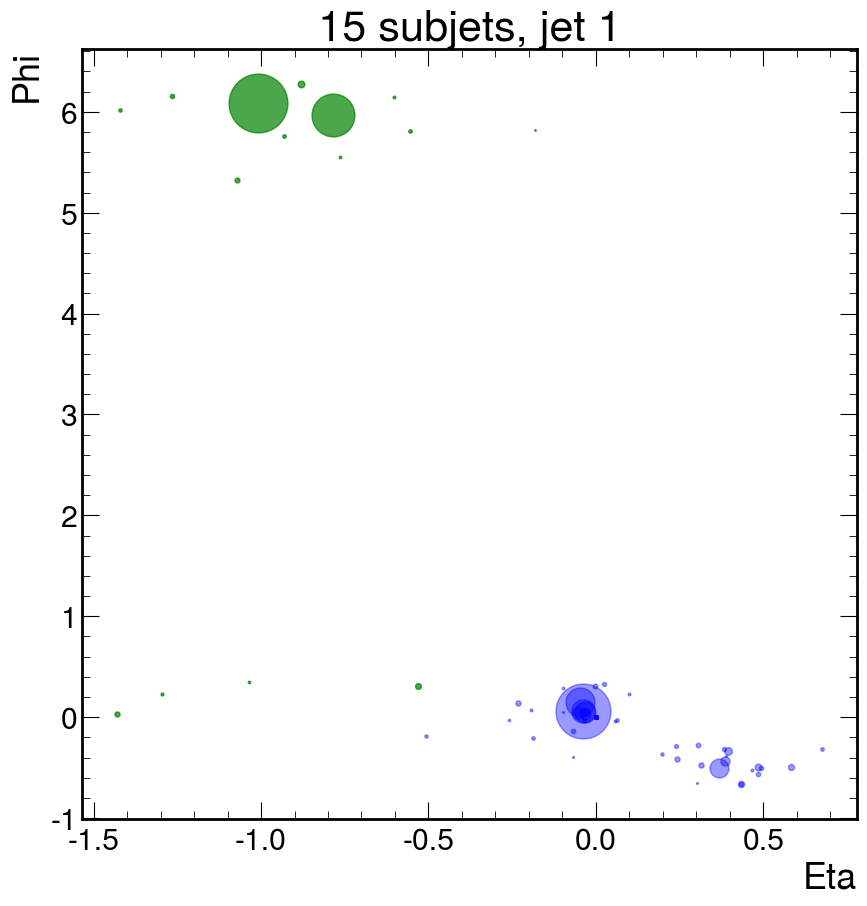

In [38]:
jet_idx = 1
jet_data = good_jets[jet_idx]
# Plotting the jet in the eta-phi plane
fig, ax = plt.subplots()
num_real_subjets = get_num_real_subjets(jet_data)
for i in range(num_real_subjets):
    subjet = jet_data[i]
    eta, phi, pT = subjet['features']['eta'], subjet['features']['phi'], subjet['features']['pT']
    ax.scatter(eta, phi, s=pT * 5, c='green',alpha=0.7)  # Multiply by 100 to scale up the marker size
for j in range(128):
    eta_part, phi_part, log_pT_part, log_e_part = particles_features[jet_idx, :, j]
    pT_part = np.exp(log_pT_part)
    ax.scatter(eta_part, phi_part, s=pT_part * 5, c='blue',alpha=0.4)
    # for j in range(subjet['features']['num_ptcls']):
    #     ptcl_idx = subjet['indices'][j]
    #     ptcl = particles_features[jet_idx, :, ptcl_idx]
    #     eta_part, phi_part, log_pT_part, log_e_part = ptcl
    #     pT_part = np.exp(log_pT_part)
    #     ax.scatter(eta_part, phi_part, s=pT_part * 5, c='blue',alpha=0.4)  # Multiply by 100 to scale up the marker size



ax.set_xlabel('Eta')
ax.set_ylabel('Phi')
ax.set_title(f'{num_real_subjets} subjets, jet {jet_idx}')
# plt.savefig(f"{save_path}/Original_jet_{jet_idx}", bbox_inches='tight', dpi=300)
plt.show()